In [3]:
import pandas as pd
from data_imports import *
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate and save supplementary tables

In [4]:
biosamples = generate_biosample_table()
print(len(biosamples))
print(biosamples.in_unique_tumor_set.sum())
print(biosamples.in_unique_patient_set.sum())
biosamples.head()

/Users/ochapman/projects/pedpancan_ecdna/2023-12-06_yet-another-metadata-adventure/data_imports.py:147: DtypeWarning: Columns (1,21,24,25,26,27,33,36,37,41,43,45,47,48,49,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep='\t',index_col=0)


53 KF biospecimens missing from the opentarget histologies table...
found 41 matching external sample IDs, adding to table...
1684
1522
1506


,sex,patient_id,external_sample_id,tumor_history,age_at_diagnosis,cohort,extent_of_tumor_resection,cancer_type,ecDNA_sequences_detected,amplicon_class,in_unique_tumor_set,in_unique_patient_set
BS_AQMKA8NC,Male,PT_00G007DM,7316-2577,Recurrence,3178.0,PBTA-X00,Gross/Near total resection,ETMR,0.0,No amplification,False,False
BS_K07KNTFY,Male,PT_00G007DM,7316-272,Diagnosis,464.0,PBTA-X00,Gross/Near total resection,ETMR,1.0,ecDNA,True,True
BS_TE8QFF7T,Male,PT_01MZ62KG,7316-447,Progressive,546.0,PBTA-X00,Partial resection,ETMR,1.0,ecDNA,True,True
BS_2VB8649B,Male,PT_02J5CWN5,7316-2989,Diagnosis,2223.0,PBTA-X00,Partial resection,LGG,0.0,No amplification,False,False
BS_5TT6TT4K,Male,PT_02J5CWN5,7316-898,Progressive,3722.0,PBTA-X00,Partial resection,LGG,0.0,No amplification,True,True


In [6]:
patients = generate_patient_table()

/Users/ochapman/projects/pedpancan_ecdna/2023-12-06_yet-another-metadata-adventure/data_imports.py:147: DtypeWarning: Columns (1,21,24,25,26,27,33,36,37,41,43,45,47,48,49,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep='\t',index_col=0)


53 KF biospecimens missing from the opentarget histologies table...
found 41 matching external sample IDs, adding to table...


/Users/ochapman/projects/pedpancan_ecdna/2023-12-06_yet-another-metadata-adventure/data_imports.py:147: DtypeWarning: Columns (1,21,24,25,26,27,33,36,37,41,43,45,47,48,49,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep='\t',index_col=0)


53 KF biospecimens missing from the opentarget histologies table...
found 41 matching external sample IDs, adding to table...


In [8]:
# Generate Supplementary tables
biosamples.to_csv("out/Supplementary Table 2.tsv",sep='\t')
patients.to_csv("out/Supplementary Table 1.tsv",sep='\t')

# Summary statistics

In [18]:
# How many patients with ecDNA?
ec=len(patients[patients.amplicon_class == 'ecDNA'])
nec=len(patients)
print(f"Number of ecDNA+ patients: {ec}")
print(f"Total number of patients: {nec}")
print(f"fraction of ecDNA+ patients: {ec/nec}")

Number of ecDNA+ patients: 156
Total number of patients: 1506
fraction of ecDNA+ patients: 0.10358565737051793


In [19]:
# How many unique tumor types?
print(f"Number of tumor types: {len(biosamples.cancer_type.unique())}")

# How many tumor types with >=n biosamples?
n=5
tmp = biosamples[biosamples.in_unique_tumor_set]
gby = tmp.groupby("cancer_type").count().ecDNA_sequences_detected
print(f"Number of tumor types with >= {n} tumors: {len(gby[gby >=n])}")

# How many tumor types with ecDNA?
ect = biosamples[biosamples.amplicon_class == "ecDNA"].cancer_type.unique()
print(f"Number of tumor types with ecDNA: {len(ect)}")
print(f"Tumor types with ecDNA: {', '.join(ect)}")

# How many tumor types with >=4 biosamples and ecDNA?
ect = set(ect)
m = set(gby[gby >= n].index)
print(f"Number of tumor types with ecDNA and >= {n} tumors: {len(ect & m)}")
#print(f"Tumor types with ecDNA and >= 4 tumors: {', '.join(n & m)}")

# Which ecDNA+ tumors are excluded when we set an n threshold?
print(f"ecDNA+ tumors with fewer than {n} unique biosamples: {', '.join(ect - m)}")


Number of tumor types: 45
Number of tumor types with >= 5 tumors: 29
Number of tumor types with ecDNA: 19
Tumor types with ecDNA: ETMR, HGG, RMS, EPN, GNT, CPT, MBL, MPNST, PBL, NBL, MST, CPG, OST, LGG, RBL, ACC, WLM, SARC, GCT
Number of tumor types with ecDNA and >= 5 tumors: 17
ecDNA+ tumors with fewer than 5 unique biosamples: MPNST, MST


In [36]:
# How many ecDNAs detected?
SUPPLEMENTARY_TABLES_PATH="/Users/ochapman/projects/pedpancan_ecdna/data/Supplementary Tables.xlsx"
def import_amplicons():
    df = pd.read_excel(SUPPLEMENTARY_TABLES_PATH,sheet_name="3. Amplicons")
    # exclude X01, for now.
    df = df[~df.sample_name.str.startswith('PT')]
    return df
amplicons = import_amplicons()
amplicons.head()

,sample_name,amplicon_number,amplicon_decomposition_class,ecDNA+,BFB+,ecDNA_amplicons
0,BS_A9S5HT6P,amplicon1,No amp/Invalid,None detected,None detected,0
1,BS_XEVMEYFS,amplicon1,Cyclic,Positive,None detected,1
2,BS_XEVMEYFS,amplicon2,No amp/Invalid,None detected,None detected,0
3,BS_59FR1NC2,amplicon1,Linear,None detected,None detected,0
4,BS_GRECE8Q9,amplicon1,No amp/Invalid,None detected,None detected,0


In [51]:
ss = amplicons[amplicons["ecDNA+"] == "Positive"]
n_ecDNA = len(ss)
print(f"Number of ecDNA sequences detected: {n_ecDNA}")

bb = biosamples[(biosamples.amplicon_class == "ecDNA")]
n_ecDNA_samples = len(bb)
print(f"Number of ecDNA+ samples: {n_ecDNA_samples}")

n_ecDNA_patients = len(bb.patient_id.unique())
print(f"Number of ecDNA+ patients: {n_ecDNA_patients}")

Number of ecDNA sequences detected: 205
Number of ecDNA+ samples: 178
Number of ecDNA+ patients: 156


In [52]:
# What other sarcomas have ecDNA?
biosamples[(biosamples.cancer_type == "SARC") & (biosamples.amplicon_class == "ecDNA")]

,sex,patient_id,external_sample_id,tumor_history,age_at_diagnosis,cohort,extent_of_tumor_resection,cancer_type,ecDNA_sequences_detected,amplicon_class,in_unique_tumor_set,in_unique_patient_set
SJST030131_D3,Male,SJ030131,NaN,Diagnosis,6059.0,"SJC-DS-1008,SJC-DS-1004",NaN,SARC,2.0,ecDNA,True,True
SJBT030809_D1,Male,SJ030809,NaN,Diagnosis,3791.0,SJC-DS-1007,NaN,SARC,1.0,ecDNA,True,True


In [10]:
# data
ct = pd.crosstab(biosamples.cancer_type, biosamples.ecDNA_sequences_detected > 0)
ct['Total'] = ct.apply(sum,axis='columns')
ct.sort_values('Total',ascending=False,inplace=True)
ct.rename(columns={False:'no ecDNA',True:'ecDNA'},inplace=True)
ct.head()

ecDNA_sequences_detected,no ecDNA,ecDNA,Total
cancer_type,,,
LGG,307,1,308
HGG,173,40,213
MBL,163,28,191
NBL,80,34,114
GNT,93,1,94


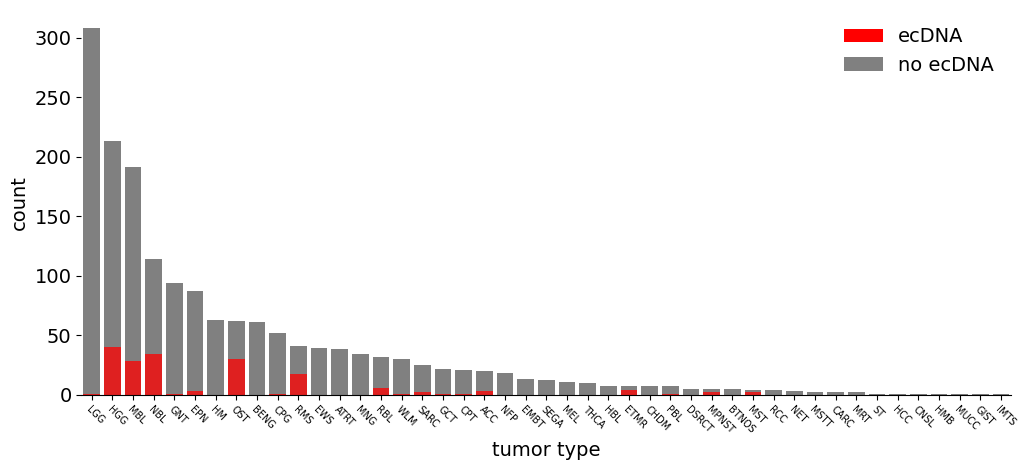

In [9]:
def all_tumors_x_ecDNA_stacked_barplot(ct, svgfile=None):
    cats = ['ecDNA','no ecDNA']
    colors={'ecDNA':'red','no ecDNA':'grey'}

    # legend
    plt.figure(figsize=(12,5))
    l = plt.legend(handles=[plt.Rectangle((0,0),1,1,fc=colors[c],edgecolor='none') for c in cats],
                  labels=cats, loc='upper right',frameon=False,ncol=1,prop={'size':14})
    # plot
    p=recursive_stacked_barplot(ct,cats,colors)
    # axes
    sns.despine(left=True)
    p.set_xticklabels(p.get_xticklabels(), rotation=-45,horizontalalignment='left',rotation_mode="anchor")
    p.set_xlabel("tumor type")
    p.set_ylabel("count")
    #p.set_ylim(0,20)
    #p.set_yticks(range(0,20,5))
    for item in ([p.xaxis.label, p.yaxis.label] +
            p.get_yticklabels()):
        item.set_fontsize(14)
    for item in p.get_xticklabels():
        item.set_fontsize(7)
    # save
    if svgfile != None:
        plt.savefig(svgfile)


def recursive_stacked_barplot(df,cats,colors):
    if len(cats) == 0:
        pass
    else:
        # make barplot
        df = df[cats]
        y = df.apply(sum,axis='columns')
        p=sns.barplot(x = df.index, y=y, color=colors[cats[-1]])
        # recurse
        recursive_stacked_barplot(df,cats[:-1],colors)
        return p
    
## This plot has too many tumor types to be very readable but shows that we have a long tail of tumor types, and the long tail is ecDNA-.
all_tumors_x_ecDNA_stacked_barplot(ct)

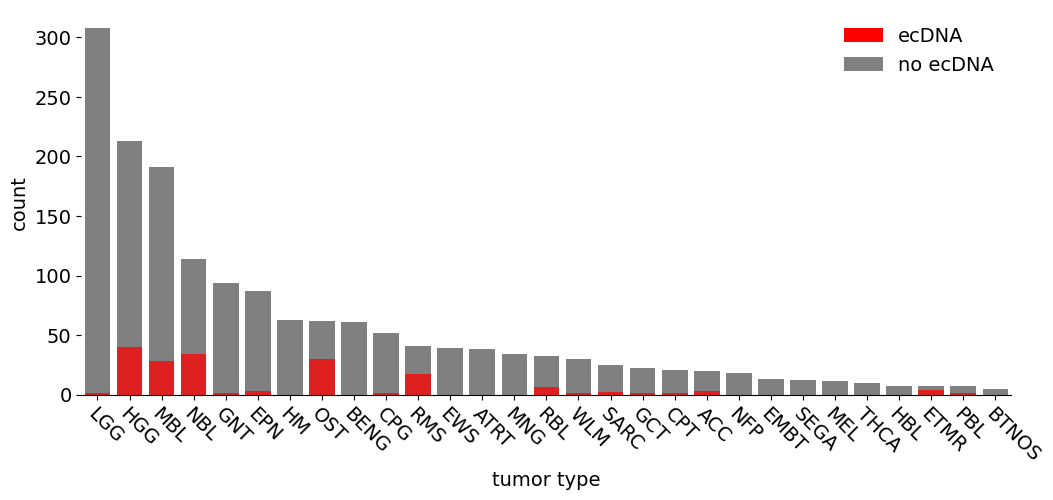

In [10]:
def geqn_tumors_x_ecDNA_stacked_barplot(ct, svgfile=None):
    cats = ['ecDNA','no ecDNA']
    colors={'ecDNA':'red','no ecDNA':'grey'}

    # legend
    plt.figure(figsize=(12,5))
    l = plt.legend(handles=[plt.Rectangle((0,0),1,1,fc=colors[c],edgecolor='none') for c in cats],
                  labels=cats, loc='upper right',frameon=False,ncol=1,prop={'size':14})
    # plot
    p=recursive_stacked_barplot(ct,cats,colors)
    # axes
    sns.despine(left=True)
    p.set_xticklabels(p.get_xticklabels(), rotation=-45,horizontalalignment='left',rotation_mode="anchor")
    p.set_xlabel("tumor type")
    p.set_ylabel("count")
    #p.set_ylim(0,20)
    #p.set_yticks(range(0,20,5))
    for item in ([p.xaxis.label, p.yaxis.label] +
            p.get_xticklabels() + p.get_yticklabels()):
        item.set_fontsize(14)
    #p.set_yscale("log")
    # save
    if svgfile != None:
        plt.savefig(svgfile)
        
tmp = biosamples[biosamples.in_unique_tumor_set]
gby = tmp.groupby("cancer_type").count().ecDNA_sequences_detected
geqn = gby[gby >= n].index
geqn_tumors_x_ecDNA_stacked_barplot(ct[ct.index.isin(geqn)])

## What changed?

In [54]:
## LGG
# Sunita's 12/23 draft: 1/290
# Revision: 1/279
def fraction_ecDNA(cancer_type):
    tmp = biosamples[biosamples.in_unique_tumor_set]
    tmp = tmp[tmp.cancer_type == cancer_type]
    print(len(tmp[tmp.ecDNA_sequences_detected > 0]))
    print(len(tmp))
fraction_ecDNA('LGG')

1
284


In [12]:
## HGG
# Sunita's 12/23 draft: 31/157
# Revision:  31/159
fraction_ecDNA('HGG')

31
159


In [13]:
## MBL
# Sunita's 12/23 draft: 25/177
# Revision: 24/178
fraction_ecDNA('MBL')

24
178


In [56]:
## NBL
# Sunita's 12/23 draft: 32/106
# Revision: 33/111
fraction_ecDNA('NBL')

33
111


In [58]:
## PBL
# Sunita's 12/23 draft: 1/4
# Revision: 1/6
fraction_ecDNA('PBL')
biosamples[biosamples.cancer_type=='PBL']

1
6


,sex,patient_id,external_sample_id,tumor_history,age_at_diagnosis,cohort,extent_of_tumor_resection,cancer_type,ecDNA_sequences_detected,amplicon_class,in_unique_tumor_set,in_unique_patient_set
BS_XJZQA3AP,Male,PT_B54PH840,7316-2707,Diagnosis,577.0,PBTA-X00,Gross/Near total resection,PBL,1.0,ecDNA,True,True
BS_H1MNXNHB,Female,PT_GNKRMTQY,7316-3856,Diagnosis,2948.0,PBTA-X00,Gross/Near total resection,PBL,0.0,No amplification,True,True
BS_9BN45DFK,Male,PT_QD6KKKJH,7316-1765,Diagnosis,3129.0,PBTA-X00,Partial resection,PBL,0.0,No amplification,False,False
BS_B91XGSA5,Male,PT_QD6KKKJH,7316-1765,Diagnosis,3129.0,PBTA-X00,Partial resection,PBL,0.0,No amplification,True,True
SJBT030154_D1,Female,SJ030154,NaN,Diagnosis,1399.0,SJC-DS-1004,NaN,PBL,0.0,No amplification,True,True
SJBT030427_D1,Male,SJ030427,NaN,Diagnosis,442.0,SJC-DS-1007,NaN,PBL,0.0,No amplification,True,True
SJBT030913_D2,Male,SJ030913,NaN,Diagnosis,3813.0,SJC-DS-1007,NaN,PBL,0.0,No amplification,True,True


In [109]:
## EPN
# Sunita's 12/23 draft: 2/73
# Revision: 2/76
fraction_ecDNA('EPN')

2
76


In [110]:
## OS
# Sunita's 12/23 draft: 27/57
# Revision: 26/55
fraction_ecDNA('OS')

26
55


In [113]:
## RMS
# Sunita's 12/23 draft: 14/35
# Revision: 15/38
fraction_ecDNA('RMS')

15
38


In [115]:
## RBL
# Sunita's 12/23 draft: 6/32
# Revision: 6/32
fraction_ecDNA('RBL')

6
32


In [117]:
## ACC
# Sunita's 12/23 draft: 2/21
# Revision: 3/20
fraction_ecDNA('ACC')

3
20


In [119]:
## CPG
# Sunita's 12/23 draft: 1/39
# Revision: 1/51
fraction_ecDNA('CPG')

1
51


In [120]:
## GG
# Sunita's 12/23 draft: 1/44
# Revision: 1/48
fraction_ecDNA('GG')

1
48


In [121]:
## ETMR
# Sunita's 12/23 draft: 4/4
# Revision: 4/6
fraction_ecDNA('ETMR')


4
6


In [123]:
## PBL
# Sunita's 12/23 draft: 1/4
# Revision: 1/6
fraction_ecDNA('PBL')

1
6


In [20]:
fraction_ecDNA('SCSNOS')
fraction_ecDNA('CS')
fraction_ecDNA('MST')
fraction_ecDNA('GCT')
fraction_ecDNA('CPC')
fraction_ecDNA('WLM')

1
3
1
1
2
3
1
21
1
8
1
28


In [27]:
fraction_ecDNA('GNT')
fraction_ecDNA('GNBL')

0
12
0
1


In [55]:
fraction_ecDNA('EWS')

0
36


In [59]:
fraction_ecDNA('BENG')

0
58


In [18]:
biosamples[biosamples.cancer_type == "SCT"]

,sex,patient_id,external_sample_id,tumor_history,age_at_diagnosis,cohort,extent_of_tumor_resection,cancer_type,ecDNA_sequences_detected,amplicon_class,in_unique_tumor_set,in_unique_patient_set
BS_4Z6F1HJZ,Male,PT_6PFFSB6D,7316-2569,Diagnosis,5690.0,PBTA-X00,Partial resection,SCT,0.0,No amplification,True,True


## NFP and MPNST
Summary: No NFPs have ecDNA. 1 patient with MPNST had ecDNA; both are recurrences; primary not in the dataset.

In [65]:
biosamples[biosamples.cancer_type == 'MPNST']

,sex,patient_id,external_sample_id,tumor_history,age_at_diagnosis,cohort,extent_of_tumor_resection,cancer_type,ecDNA_sequences_detected,amplicon_class,in_unique_tumor_set,in_unique_patient_set
BS_6Z213H2V,None,PT_2E552BAR,7316-3066,Progressive,7300.0,PBTA-X00,Partial resection,MPNST,0.0,No amplification,True,True
BS_WH8KWW5J,Male,PT_9PJR0ZK7,7316-2576,Recurrence,6879.0,PBTA-X00,Partial resection,MPNST,1.0,ecDNA,False,False
BS_A1DV9T7G,Male,PT_9PJR0ZK7,7316-935,Progressive,6431.0,PBTA-X00,Partial resection,MPNST,2.0,ecDNA,True,True
BS_Z1BBZ01F,None,PT_QQ9JGEY9,7316-356,Diagnosis,6349.0,PBTA-X00,Partial resection,MPNST,0.0,No amplification,True,True
SJMPNST030013_D1,None,SJ030013,NaN,Diagnosis,NaN,SJC-DS-1003,NaN,MPNST,0.0,No amplification,True,True


In [86]:
biosamples[(biosamples.cancer_type == 'NFP') & (biosamples.ecDNA_sequences_detected > 0)]

,sex,patient_id,external_sample_id,tumor_history,age_at_diagnosis,cohort,extent_of_tumor_resection,cancer_type,ecDNA_sequences_detected,amplicon_class,in_unique_tumor_set,in_unique_patient_set


In [84]:
biosamples[biosamples.patient_id == 'PT_9PJR0ZK7'

,sex,patient_id,external_sample_id,tumor_history,age_at_diagnosis,cohort,extent_of_tumor_resection,cancer_type,ecDNA_sequences_detected,amplicon_class,in_unique_tumor_set,in_unique_patient_set
BS_WH8KWW5J,Male,PT_9PJR0ZK7,7316-2576,Recurrence,6879.0,PBTA-X00,Partial resection,MPNST,1.0,ecDNA,False,False
BS_A1DV9T7G,Male,PT_9PJR0ZK7,7316-935,Progressive,6431.0,PBTA-X00,Partial resection,MPNST,2.0,ecDNA,True,True
